# <center>GAIT ANALYSIS</center>
***
### Import Necessary Libraries

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms
import os
import sys

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Initialize the Deeplab Model for person identification purposes

In [3]:
def make_deeplab(device):
    deeplab = deeplabv3_resnet101(pretrained=True).to(device)
    deeplab.eval()
    return deeplab

In [4]:
device = torch.device("cpu")
deeplab = make_deeplab(device)

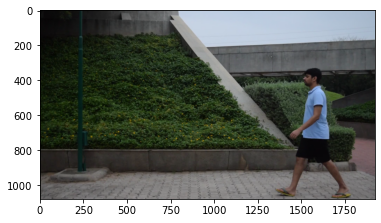

In [5]:
f_name = "Gait Cycle/sarwesh/1.png"
img_orig = cv2.imread(f_name, 1)
plt.imshow(img_orig[:, :, ::-1])
plt.show()

In [6]:
k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Function to use DeepLab for person's gait phase image

In [7]:
def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()
    return (output_predictions == 15)

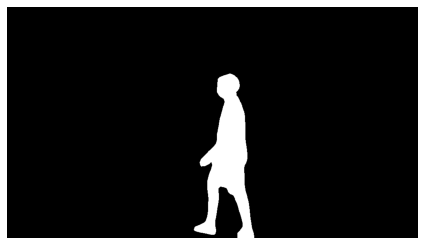

In [42]:
mask = apply_deeplab(deeplab, img, device)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.show()
plt.imsave('Silhouttes/new.jpg', mask, cmap='gray')

In [101]:
DATA_DIR = "Test Cycle/Praneeth"
images = os.listdir(DATA_DIR)
images

['IMG-20230423-WA0123.jpg',
 'IMG-20230423-WA0125.jpg',
 'IMG-20230423-WA0126.jpg',
 'IMG-20230423-WA0127.jpg',
 'IMG-20230423-WA0128.jpg',
 'IMG-20230423-WA0129.jpg',
 'IMG-20230423-WA0130.jpg',
 'IMG-20230423-WA0131.jpg']

### Extarcting Silhouttes

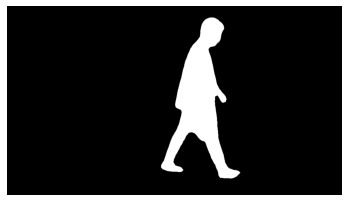

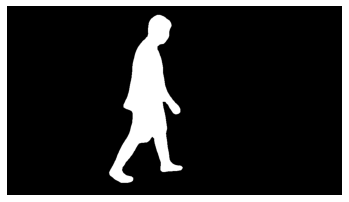

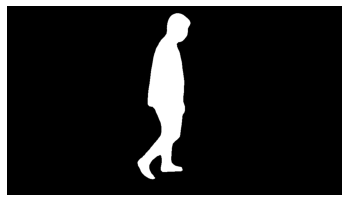

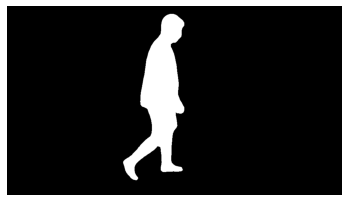

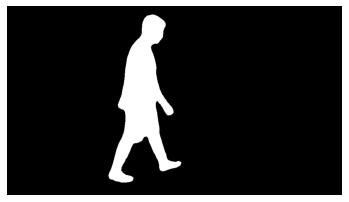

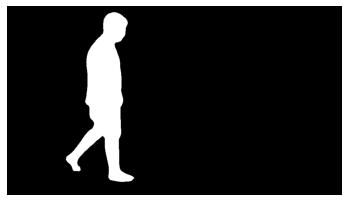

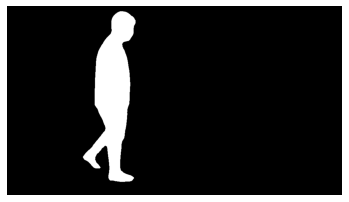

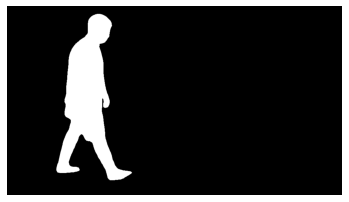

In [102]:
silhouttes = []
count = 1
for img_file in images:
    f_name = DATA_DIR + '/' + img_file
    img_orig = cv2.imread(f_name, 1)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

    deeplab_preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    mask = apply_deeplab(deeplab, img, device)
    silhouttes.append(mask)

    plt.imshow(mask, cmap="gray")
    plt.axis('off')
    plt.show()
    plt.imsave('Test Silhouttes/'+DATA_DIR[11:]+'/'+str(count)+'.jpg', mask, cmap='gray')
    count += 1

### Function to center the Silhoutte

In [10]:
def center_silhoutte(sil_img_path):
    img = cv2.imread(sil_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get shape
    hh, ww = img.shape


    # get contours (presumably just one around the nonzero pixels) 
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)

    # recenter
    startx = (ww - w)//2
    starty = (hh - h)//2
    result = np.zeros_like(img)
    result[starty:starty+h,startx:startx+w] = img[y:y+h,x:x+w]

    # view result
    # plt.imshow(result,cmap='gray')
    return(result)

In [103]:
sil_img_temp = cv2.imread('Test Silhouttes/Praneeth/1.jpg')
sil_h = sil_img_temp.shape[0]
sil_w = sil_img_temp.shape[1]

### Calculate the Gait Energy Image (GEI)

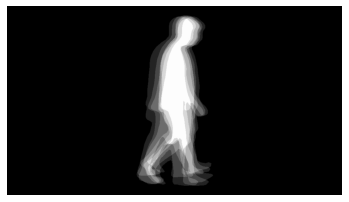

In [104]:
sil_imgs = os.listdir('Test Silhouttes/Praneeth')
img_total = np.zeros((sil_h,sil_w))

for sil_img_path in sil_imgs:
    res = center_silhoutte('Test Silhouttes/Praneeth/'+sil_img_path)
    img_total += res

img_mean = img_total//len(sil_imgs)
img_mean = img_mean.astype('uint8')
plt.imshow(img_mean,cmap='gray')
plt.axis('off')
plt.imsave('sil_out.jpg',img_mean,cmap='gray')

### Finding the Distance between the images

In [17]:
test_img = cv2.imread("Test Images/Utkarsh.png")
DATA_IMG_DIR = "Database Images/"
db_imgs = os.listdir(DATA_IMG_DIR)

for db_img in db_imgs:
    f_name = DATA_IMG_DIR + db_img
    act_img = cv2.imread(f_name)
    
    gray1 = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(act_img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)

    distance = sum([match.distance for match in matches]) / len(matches)

    print(distance, db_img)

278.8898637559679 Anirudh.png
263.5741990831163 Bhargav.png
263.2673522101508 Dheeraj.png
269.57352583143444 Dinesh.png
263.69752078586157 Hemanth.png
276.68055169847275 Hitesh.png
276.8959770202637 Indraneel.png
258.58024156358505 Lokesh.png
255.27505984836154 Praneeth.png
284.38620732625327 Tejaswi.png
239.30214106241863 Utkarsh.png
285.8052268981934 Vishnu.png


***
# Other attempts to perform Gait Recognition (not used in our case, hence unnecessary)
***

### Using Matrix features to do predictions

In [139]:
file_names = os.listdir("Database Images/")
count = 1
names = {}
for f_nm in file_names: 
    gei = cv2.imread('Database Images/'+f_nm, cv2.IMREAD_GRAYSCALE)
    _, binary_gei = cv2.threshold(gei, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    num_shell_outs = 13
    height, width = binary_gei.shape
    shell_out_width = width // num_shell_outs
    shell_outs = []
    for i in range(num_shell_outs):
        shell_out = binary_gei[:, i*shell_out_width:(i+1)*shell_out_width]
        shell_outs.append(shell_out)
    means = [np.mean(shell_out) for shell_out in shell_outs]
    feature_vector = np.array(means)
    names[count] = feature_vector
    count += 1

In [140]:
test_files = os.listdir("Test Images/")
preds = []
for tst_fl in test_files:
    dist = sys.maxsize
    label = 0
    
    gei = cv2.imread('Test Images/'+tst_fl, cv2.IMREAD_GRAYSCALE)
    _, binary_gei = cv2.threshold(gei, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    num_shell_outs = 13
    height, width = binary_gei.shape
    shell_out_width = width // num_shell_outs
    shell_outs = []
    for i in range(num_shell_outs):
        shell_out = binary_gei[:, i*shell_out_width:(i+1)*shell_out_width]
        shell_outs.append(shell_out)
    means = [np.mean(shell_out) for shell_out in shell_outs]
    feature_vector = np.array(means)
    
    count = 1
    curr_dist = 0
    for keys in names.keys():
        db_features = np.array(names[count])
        curr_dist = abs(np.linalg.norm(db_features-feature_vector))
        if(curr_dist < dist):
            dist = curr_dist
            label = count
        count += 1
    preds.append(label)
preds

[9, 5, 3, 9, 8, 7, 2, 8, 9, 10, 6, 11]

### Using Gabor Filter to Extract Features

In [28]:
def build_filters():
        filters = []
        ksize = 31
        for theta in np.arange(0, np.pi, np.pi / 16):
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
            return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
        return accum

In [32]:
img = cv2.imread('sil_out.jpg',0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  
ret, labels = cv2.connectedComponents(img)
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue==0] = 0
cv2.imshow('labeled.png', labeled_img)
cv2.waitKey()

-1

In [33]:
filters = build_filters()
res1 = process(img,filters)
cv2.imshow('result',res1)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Haarcascade Full Body Code (Not required right now)

In [18]:
import cv2

# Load the pre-trained Haar Cascade file for full body detection
body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

# Read the input image
img = cv2.imread('side walk video.jpg')

# Convert the input image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect the profile body in the input image
bodies = body_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

# Draw a rectangle around the detected profile body in the input image
for (x, y, w, h) in bodies:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display the output image with the detected profile body
cv2.imshow('Output', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [89]:
cap = cv2.VideoCapture('data/Side walk net 3.mp4')

bike_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

while True:
    ret, img = cap.read()
	
    
    if (type(img) == type(None)):
        break
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bike = bike_cascade.detectMultiScale(gray,1.3,2)

    for(a,b,c,d) in bike:
        cv2.rectangle(img,(a,b),(a+c,b+d),(0,255,210),4)
    
    cv2.imshow('video', img)
    
    if cv2.waitKey(33) == 27:
        break

cv2.destroyAllWindows()


# <center>---End of Notebook---</center>